##  Library Imports and Data Loading

In [ ]:
# Install and import torchaudio for audio processing
!pip install torchaudio


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install umap-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install transformers==4.47.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!which python
!pip show torchaudio


'which' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


Name: torchaudio
Version: 2.5.1
Summary: An audio package for PyTorch
Home-page: https://github.com/pytorch/audio
Author: Soumith Chintala, David Pollack, Sean Naren, Peter Goldsborough, Moto Hira, Caroline Chen, Jeff Hwang, Zhaoheng Ni, Xiaohui Zhang
Author-email: soumith@pytorch.org
License: 
Location: C:\Users\leami\anaconda3\Lib\site-packages
Requires: torch
Required-by: demucs, openunmix


In [ ]:
!pip install librosa


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install umap-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import necessary libraries
from transformers import ClapModel, ClapProcessor, AutoModel, Wav2Vec2FeatureExtractor # CLAP and MERT models
import numpy as np # Data manipulation tool
import torch # Neural network development module
import torchaudio # Audio processing module
import torchaudio.transforms as T # Transforms for audio (spectrogram and everything)
from torchaudio import load # Loader for audio files
from librosa import power_to_db
from sklearn.metrics import pairwise_distances  # Cosine similarity
import os
import random
import glob
import pathlib
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") # Specify the model to make inference
# # you can also set this parameter manually (if you have only one gpu, use "cuda:0", or use "cpu" if you don't have a gpu)

In [ ]:

path = "./processed/separated/htdemucs"
print(os.listdir(path))  # List the files


['Bam Bam - Hi-Q', 'Benji Cossa - New Flowers (Fast 4-track Version)', 'Bessie Smith - My Sweetie Went Away', 'David Rovics - We Just Want The World', 'deef - Ein sonniger Tag mit dir', 'Dragon Or Emperor - Part of Me Says', 'Grand Mal - Children of Light', 'Home Blitz - Secret Wave', 'Josh Woodward - Cien Volando', 'Los Steaks - Sunday Girls', 'Mia Doi Todd - I gave you my home', 'Orange Peels - Grey Holiday', 'Poland - Lying Machine', 'Shearer - Itch', 'Short Hand - Certain Strangers', 'The Cute Lepers - Young Hearts', 'The Embarrassment - Patio Set', 'The J Arthur Keenes Band - The Boring World of Niels Bohr', 'The Oranges Band - Ride the Nuclear Wave', 'Wann - Happy Birthday', 'ZOELEELA - Jewel']


In [ ]:
# A folder containing the mp3 files
audio_folder=path

# Listing of all the mp3 files in the folder
mp3_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]

#Randomly select of 400 files (or less if there's less)
random.seed(42)  # Set the seed for reproductible results
mp3_files = random.sample(mp3_files, min(1000, len(mp3_files)))

# Checking
print(f"{len(mp3_files)} fichiers sélectionnés : {mp3_files[:10]} (affichage limité)")


0 fichiers sélectionnés : [] (affichage limité)


## Model Implementation

In [ ]:
# Load the models
cpt1 = "laion/clap-htsat-unfused" # Name of the model. The CLAP HTSAT UNFUSED model is a generalistic one, trained on LAION Audio 630k
processor_general = ClapProcessor.from_pretrained(cpt1)
model_general = ClapModel.from_pretrained(cpt1).to(device)

# Prints the model
# Model_general.eval()

In [ ]:
!rm -rf ~/.cache/huggingface

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
model = AutoModel.from_pretrained("m-a-p/MERT-v1-95M", trust_remote_code=True).to("cuda")
processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-95M", trust_remote_code=True)


# Prints the model
# Model.eval()

##  Model Implementation

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T

# Folder containing the separated tracks
htdemucs_folder = "./processed/separated/htdemucs"
clap_sr = 48000  # Target sampling frequence for CLAP

# Initialisation of embeddings' dictionnary
audio_embeddings_clap = {}
error_files = []  # Files sending error messages

# Loading and preprocessing audio files function
def load_and_preprocess(file_path):
    waveform, base_sr = load(file_path)

# Resample to 48000 hz if necessary
    if base_sr != clap_sr:
        resampler = T.Resample(base_sr, clap_sr)
        waveform = resampler(waveform)

# Convert to mono if necessary
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=False)
    else:
        waveform = waveform.squeeze()

# Truncate  to 10 seconds maximum
    return waveform[:(10 * clap_sr)]


# **parcourir tous les dossiers des musiques**
for music_folder in os.listdir(htdemucs_folder):
    music_path = os.path.join(htdemucs_folder, music_folder)

    if not os.path.isdir(music_path):
        continue  # Ignorer les fichiers éventuels dans htdemucs

    print(f"\n🔹 Traitement de la musique : {music_folder}")

    vocals_path = os.path.join(music_path, "vocals.wav")
    bass_path = os.path.join(music_path, "bass.wav")
    drums_path = os.path.join(music_path, "drums.wav")
    other_path = os.path.join(music_path, "other.wav")

# **traitement des vocaux**
    if os.path.exists(vocals_path):
        try:
            print(f"🎤 Traitement de {music_folder}_vocals")
            waveform_vocals = load_and_preprocess(vocals_path)

# Prétraitement pour le modèle clap
            inputs_audio = processor_general(audios=waveform_vocals.numpy(), sampling_rate=clap_sr, return_tensors="pt", padding=True)
            inputs_audio = {key: value.to(device) for key, value in inputs_audio.items()}

# Générer l'embedding audio
            with torch.inference_mode():
                embedding = model_general.get_audio_features(**inputs_audio)

# Stocker l'embedding avec une clé unique
            audio_embeddings_clap[f"{music_folder}_vocals"] = embedding.cpu().numpy()
            print("✅ Embedding généré pour vocals")

        except Exception as e:
            print(f"❌ Erreur pour {music_folder}_vocals : {e}")
            error_files.append(f"{music_folder}_vocals")

# **additionner les fichiers instrumentaux**
    instrumental_waveform = None

    for inst_path in [bass_path, drums_path, other_path]:
        if os.path.exists(inst_path):
            try:
                print(f"🎸🔊🔔 Chargement de {inst_path} pour l'addition instrumentale")
                waveform = load_and_preprocess(inst_path)

# Additionner les pistes instrumentales
                if instrumental_waveform is None:
                    instrumental_waveform = waveform
                else:
                    instrumental_waveform = instrumental_waveform[:waveform.shape[0]] + waveform[:instrumental_waveform.shape[0]]

            except Exception as e:
                print(f"❌ Erreur pour {inst_path} : {e}")
                error_files.append(inst_path)

# **traitement du fichier instrumental combiné**
    if instrumental_waveform is not None:
        try:
            print(f"🎼 Traitement de {music_folder}_instrumental")

# Prétraitement pour le modèle clap
            inputs_audio = processor_general(audios=instrumental_waveform.numpy(), sampling_rate=clap_sr, return_tensors="pt", padding=True)
            inputs_audio = {key: value.to(device) for key, value in inputs_audio.items()}

# Générer l'embedding audio
            with torch.inference_mode():
                embedding = model_general.get_audio_features(**inputs_audio)

# Stocker l'embedding avec une clé unique
            audio_embeddings_clap[f"{music_folder}_instrumental"] = embedding.cpu().numpy()
            print("✅ Embedding généré pour instrumental")

        except Exception as e:
            print(f"❌ Erreur pour {music_folder}_instrumental : {e}")
            error_files.append(f"{music_folder}_instrumental")

# **résumé des erreurs**
if error_files:
    print(f"\n⚠️ Fichiers ayant causé des erreurs : {error_files}")
else:
    print("\n✅ Tous les fichiers ont été traités avec succès.")



🔹 Traitement de la musique : Bam Bam - Hi-Q
🎤 Traitement de Bam Bam - Hi-Q_vocals
✅ Embedding généré pour vocals
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\bass.wav pour l'addition instrumentale
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\drums.wav pour l'addition instrumentale
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\other.wav pour l'addition instrumentale
🎼 Traitement de Bam Bam - Hi-Q_instrumental
✅ Embedding généré pour instrumental

🔹 Traitement de la musique : Benji Cossa - New Flowers (Fast 4-track Version)
🎤 Traitement de Benji Cossa - New Flowers (Fast 4-track Version)_vocals
✅ Embedding généré pour vocals
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Benji Cossa - New Flowers (Fast 4-track Version)\bass.wav pour l'addition instrumentale
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Benji Cossa - New Flowers (Fast 4-track Version)\drums.wav pour l'addition instrumentale
🎸🔊🔔 Chargement de ./processed/separat

In [ ]:
audio_embeddings_clap


{'Bam Bam - Hi-Q_vocals': array([[-7.71480240e-03, -2.28445977e-03,  5.85205154e-03,
         -3.55710462e-02, -2.19568107e-02,  2.58312244e-02,
         -8.37206002e-03, -1.04471846e-02,  4.28922921e-02,
         -2.73719546e-03, -6.16190210e-02, -5.98822422e-02,
          2.68143713e-02, -1.10864714e-02,  2.90685706e-02,
          4.35589999e-02, -4.06461842e-02, -2.89997198e-02,
         -2.37082504e-02,  5.23521826e-02, -4.96723354e-02,
          5.14101498e-02, -6.13296553e-02, -6.46512285e-02,
         -1.01396441e-02,  1.44736366e-02, -7.14357942e-02,
         -4.83083725e-02,  1.29689919e-02,  4.41055261e-02,
         -5.48317283e-02,  7.54160285e-02, -4.74520661e-02,
         -5.94776161e-02,  3.49082518e-03, -6.73507303e-02,
         -2.99609732e-03,  2.26923116e-02, -2.65615005e-02,
         -5.19909188e-02, -1.12552203e-01, -2.51128059e-02,
         -1.51974903e-02,  5.14820442e-02,  7.42572453e-03,
         -4.82899621e-02,  5.88880442e-02, -1.24176769e-02,
         -2.171

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T

# Dossier contenant les musiques séparées
htdemucs_folder = "./processed/separated/htdemucs"
mert_sr = processor.sampling_rate  # Fréquence cible de MERT

# Dictionnaire pour stocker les embeddings
audio_embeddings_mert = {}

# Liste des fichiers en erreur
error_files = []

# Fonction de chargement et prétraitement audio
def load_and_preprocess(file_path, target_sr):
    print(f"📥 Chargement de {file_path}")  # Debug
    waveform, base_sr = torchaudio.load(file_path)

# Resample à la fréquence cible si nécessaire
    if base_sr != target_sr:
        resampler = T.Resample(base_sr, target_sr)
        waveform = resampler(waveform)

# Convertir en mono si nécessaire
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=False)
    else:
        waveform = waveform.squeeze()

# Tronquer à 10 secondes maximum
    return waveform[: (10 * target_sr)]


# **parcourir tous les dossiers de musiques**
for music_folder in os.listdir(htdemucs_folder):
    music_path = os.path.join(htdemucs_folder, music_folder)

    if not os.path.isdir(music_path):
        continue  # Ignorer les fichiers éventuels

    print(f"\n🔹 Traitement de la musique : {music_folder}")

    vocals_path = os.path.join(music_path, "vocals.wav")
    bass_path = os.path.join(music_path, "bass.wav")
    drums_path = os.path.join(music_path, "drums.wav")
    other_path = os.path.join(music_path, "other.wav")

# **traitement des vocaux**
    if os.path.exists(vocals_path):
        try:
            print(f"🎤 Traitement de {music_folder}_vocals")
            waveform_vocals = load_and_preprocess(vocals_path, mert_sr)

# Normaliser en numpy
            input_audio = waveform_vocals.numpy()

# Appliquer la transformation mert
            inputs = processor(input_audio, sampling_rate=mert_sr, return_tensors="pt")

# Déplacer sur gpu
            inputs = {key: value.to("cuda") for key, value in inputs.items()}

# Extraire les embeddings avec mert
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

# Extraire les représentations des 13 couches cachées
            all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze()

# Moyenne temporelle pour chaque couche
            time_reduced_hidden_states = all_layer_hidden_states.mean(dim=1)  # [13, 768]

# Moyenne pondérée sur les couches via un conv1d
            aggregator = torch.nn.Conv1d(in_channels=13, out_channels=1, kernel_size=1).to("cuda")
            weighted_avg_hidden_states = aggregator(time_reduced_hidden_states.unsqueeze(0)).squeeze()  # [768]

# Stocker l'embedding
            audio_embeddings_mert[f"{music_folder}_vocals"] = weighted_avg_hidden_states.cpu().detach().numpy()
            print("✅ Embedding généré pour vocals")

        except Exception as e:
            print(f"❌ Erreur pour {music_folder}_vocals : {e}")
            error_files.append(f"{music_folder}_vocals")

# **addition des fichiers instrumentaux**
    instrumental_waveform = None

    for inst_path in [bass_path, drums_path, other_path]:
        if os.path.exists(inst_path):
            try:
                print(f"🎸🔊🔔 Chargement de {inst_path} pour l'addition instrumentale")
                waveform = load_and_preprocess(inst_path, mert_sr)

# Additionner les pistes instrumentales
                if instrumental_waveform is None:
                    instrumental_waveform = waveform
                else:
                    instrumental_waveform = instrumental_waveform[:waveform.shape[0]] + waveform[:instrumental_waveform.shape[0]]

            except Exception as e:
                print(f"❌ Erreur pour {inst_path} : {e}")
                error_files.append(inst_path)

# **traitement du fichier instrumental combiné**
    if instrumental_waveform is not None:
        try:
            print(f"🎼 Traitement de {music_folder}_instrumental")

# Normaliser en numpy
            input_audio = instrumental_waveform.numpy()

# Appliquer la transformation mert
            inputs = processor(input_audio, sampling_rate=mert_sr, return_tensors="pt")

# Déplacer sur gpu
            inputs = {key: value.to("cuda") for key, value in inputs.items()}

# Extraire les embeddings avec mert
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

# Extraire les représentations des 13 couches cachées
            all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze()

# Moyenne temporelle pour chaque couche
            time_reduced_hidden_states = all_layer_hidden_states.mean(dim=1)  # [13, 768]

# Moyenne pondérée sur les couches via un conv1d
            aggregator = torch.nn.Conv1d(in_channels=13, out_channels=1, kernel_size=1).to("cuda")
            weighted_avg_hidden_states = aggregator(time_reduced_hidden_states.unsqueeze(0)).squeeze()  # [768]

# Stocker l'embedding
            audio_embeddings_mert[f"{music_folder}_instrumental"] = weighted_avg_hidden_states.cpu().detach().numpy()
            print("✅ Embedding généré pour instrumental")

        except Exception as e:
            print(f"❌ Erreur pour {music_folder}_instrumental : {e}")
            error_files.append(f"{music_folder}_instrumental")

# **résumé des erreurs**
if error_files:
    print(f"\n🚨 Fichiers ayant causé des erreurs : {error_files}")
else:
    print("\n✅ Tous les fichiers ont été traités avec succès.")

# **afficher les clés générées pour vérifier**
print(f"\n📊 Embeddings générés : {len(audio_embeddings_mert)} fichiers")
print(audio_embeddings_mert.keys())  # Affiche les noms stockés



🔹 Traitement de la musique : Bam Bam - Hi-Q
🎤 Traitement de Bam Bam - Hi-Q_vocals
📥 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\vocals.wav
✅ Embedding généré pour vocals
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\bass.wav pour l'addition instrumentale
📥 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\bass.wav
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\drums.wav pour l'addition instrumentale
📥 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\drums.wav
🎸🔊🔔 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\other.wav pour l'addition instrumentale
📥 Chargement de ./processed/separated/htdemucs\Bam Bam - Hi-Q\other.wav
🎼 Traitement de Bam Bam - Hi-Q_instrumental
✅ Embedding généré pour instrumental

🔹 Traitement de la musique : Benji Cossa - New Flowers (Fast 4-track Version)
🎤 Traitement de Benji Cossa - New Flowers (Fast 4-track Version)_vocals
📥 Chargement de ./processed/separated/htdemucs\Benji Co

## 🤖 Model Implementation

In [ ]:
np.save("audio_embeddings_clap.npy", audio_embeddings_clap)

embedding_matrix_clap = np.load("audio_embeddings_clap.npy", allow_pickle=True)
print(type(embedding_matrix_clap))
embedding_matrix_clap = embedding_matrix_clap.item()
print(type(embedding_matrix_clap))
file_names = list(embedding_matrix_clap.keys())


# Récupère les vecteurs d'embedding (valeurs du dictionnaire)
embeddings_list_clap = list(embedding_matrix_clap.values())
embedding_matrix_clap = np.vstack(embeddings_list_clap)  # Combine les vecteurs en une matrice
print(f"Nouvelle forme de la matrice d'embeddings : {embedding_matrix_clap.shape}")




<class 'numpy.ndarray'>
<class 'dict'>
Nouvelle forme de la matrice d'embeddings : (42, 512)


In [ ]:
audio_embeddings_mert

{'Bam Bam - Hi-Q_vocals': array([-0.18884382, -0.21113074, -0.32288086, -0.14538735, -0.31294316,
        -0.13587335, -0.30018803, -0.09204648, -0.29943785, -0.20853452,
        -0.20749298, -0.1280725 , -0.17056924, -0.24514022, -0.29737335,
        -0.29802024, -0.19351915, -0.23554398, -0.2342496 , -0.2667872 ,
        -0.28298625, -0.225964  , -0.1668558 , -0.14732674, -0.23707671,
        -0.24442321, -0.23728089, -0.30332875, -0.4437328 , -0.16080664,
        -0.23494145, -0.20694995, -0.16874768, -0.22591405, -0.16398934,
        -0.25326508, -0.26086867, -0.08702347, -0.1423391 , -0.2665993 ,
        -0.21245077, -0.21119156, -0.24703969, -0.24589883, -0.13901795,
        -0.22419147, -0.25059715, -0.15766934, -0.25298545, -0.22260498,
        -0.1727697 , -0.24283485, -0.15800896, -0.24008976, -0.2718093 ,
        -0.22710901, -0.14029683, -0.19415525, -0.1585843 , -0.244517  ,
        -0.19789103, -0.18163061, -0.2932662 , -0.16233093, -0.2587149 ,
        -0.2244698 , -0.21

In [ ]:
np.save("audio_embeddings_mert.npy", audio_embeddings_mert)

embedding_matrix_mert = np.load("audio_embeddings_mert.npy", allow_pickle=True)
print(type(embedding_matrix_mert))
embedding_matrix_mert = embedding_matrix_mert.item()
print(type(embedding_matrix_mert))
file_names = list(embedding_matrix_mert.keys())


# Récupère les vecteurs d'embedding (valeurs du dictionnaire)
embeddings_list_mert = list(embedding_matrix_mert.values())
embedding_matrix_mert = np.vstack(embeddings_list_mert)  # Combine les vecteurs en une matrice
print(f"Nouvelle forme de la matrice d'embeddings : {embedding_matrix_mert.shape}")


<class 'numpy.ndarray'>
<class 'dict'>
Nouvelle forme de la matrice d'embeddings : (42, 768)


In [ ]:
# Calculer la matrice de similarité cosinus
cosine_sim_matrixc = cosine_similarity(embedding_matrix_clap)

# Afficher la forme de la matrice (n, n) et un aperçu
print(f"Forme de la matrice de similarité cosinus : {cosine_sim_matrixc.shape}")
print(cosine_sim_matrixc[:5, :5])  # Afficher les 5 premières lignes et colonnes


Forme de la matrice de similarité cosinus : (42, 42)
[[ 1.          0.3055195   0.19691084 -0.0066774   0.6966146 ]
 [ 0.3055195   1.0000004   0.313838    0.6076517   0.11763011]
 [ 0.19691084  0.313838    1.          0.37023044  0.25903034]
 [-0.0066774   0.6076517   0.37023044  1.0000002  -0.11044751]
 [ 0.6966146   0.11763011  0.25903034 -0.11044751  1.0000001 ]]


In [ ]:
# Calculer la matrice de similarité cosinus
cosine_sim_matrixm = cosine_similarity(embedding_matrix_mert)

# Afficher la forme de la matrice (n, n) et un aperçu
print(f"Forme de la matrice de similarité cosinus : {cosine_sim_matrixm.shape}")
print(cosine_sim_matrixm[:5, :5])  # Afficher les 5 premières lignes et colonnes

Forme de la matrice de similarité cosinus : (42, 42)
[[ 0.9999998   0.72897905  0.01080166  0.6339155   0.80716026]
 [ 0.72897905  1.0000002  -0.15762253  0.769144    0.71343243]
 [ 0.01080166 -0.15762253  1.         -0.1438284  -0.33607158]
 [ 0.6339155   0.769144   -0.1438284   0.9999999   0.63874084]
 [ 0.80716026  0.71343243 -0.33607158  0.63874084  0.9999999 ]]


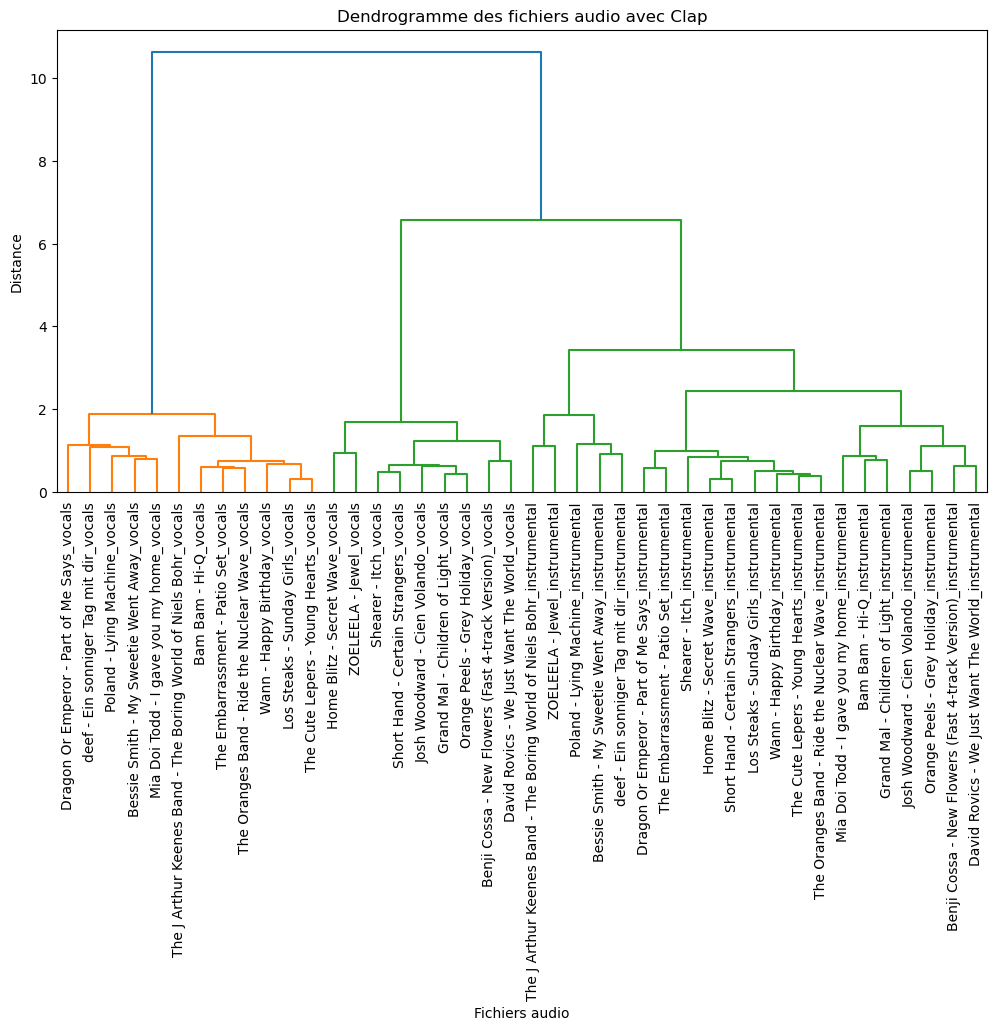

In [ ]:
# Effectuer le clustering hiérarchique à partir de la matrice de distance (1 - similarité)
linkedc = sch.linkage(1 - cosine_sim_matrixc, method='ward')

# Créer le dendrogramme
plt.figure(figsize=(12, 6))
sch.dendrogram(linkedc, labels=file_names, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogramme des fichiers audio avec Clap")
plt.xlabel("Fichiers audio")
plt.ylabel("Distance")
plt.show()

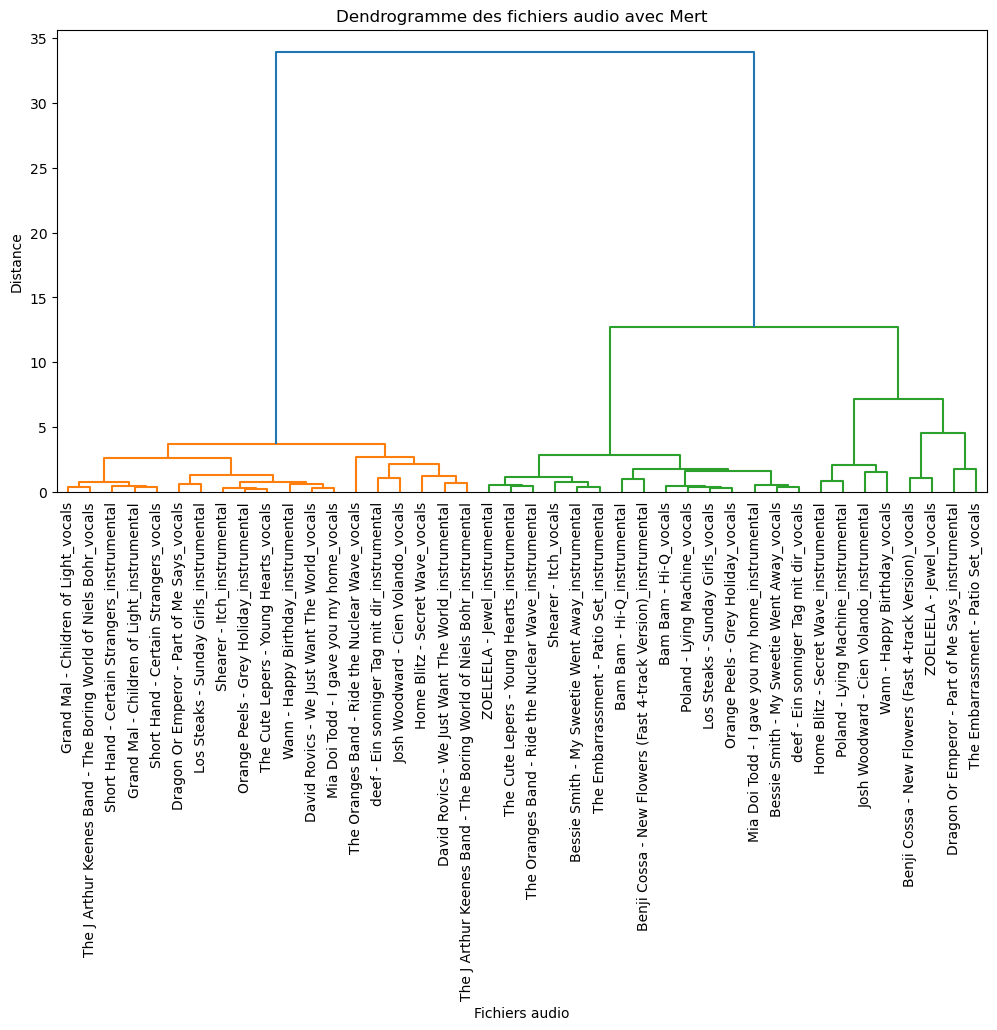

In [ ]:
# Effectuer le clustering hiérarchique à partir de la matrice de distance (1 - similarité)
linkedm = sch.linkage(1 - cosine_sim_matrixm, method='ward')

# Créer le dendrogramme
plt.figure(figsize=(12, 6))
sch.dendrogram(linkedm, labels=file_names, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogramme des fichiers audio avec Mert")
plt.xlabel("Fichiers audio")
plt.ylabel("Distance")
plt.show()

In [ ]:
threshold = 5  # À ajuster selon la structure du dendrogramme

# Extraire les clusters (plus le seuil est bas, plus il y a de clusters)
clustersc = fcluster(linkedc, threshold, criterion='distance')

# Associer chaque fichier audio à son cluster
cluster_dictc = {}
for file, cluster in zip(file_names, clustersc):
    if cluster not in cluster_dictc:
        cluster_dictc[cluster] = []
    cluster_dictc[cluster].append(file)

print(cluster_dictc.keys())

dict_keys([1, 3, 2])


In [ ]:
# Affichage des clusters avec clap
for cluster_id, files in cluster_dictc.items():
    print(f"🔹 Cluster {cluster_id}:")
    for file in files:
        print(f"  - {file}")


🔹 Cluster 1:
  - Bam Bam - Hi-Q_vocals
  - Bessie Smith - My Sweetie Went Away_vocals
  - deef - Ein sonniger Tag mit dir_vocals
  - Dragon Or Emperor - Part of Me Says_vocals
  - Los Steaks - Sunday Girls_vocals
  - Mia Doi Todd - I gave you my home_vocals
  - Poland - Lying Machine_vocals
  - The Cute Lepers - Young Hearts_vocals
  - The Embarrassment - Patio Set_vocals
  - The J Arthur Keenes Band - The Boring World of Niels Bohr_vocals
  - The Oranges Band - Ride the Nuclear Wave_vocals
  - Wann - Happy Birthday_vocals
🔹 Cluster 3:
  - Bam Bam - Hi-Q_instrumental
  - Benji Cossa - New Flowers (Fast 4-track Version)_instrumental
  - Bessie Smith - My Sweetie Went Away_instrumental
  - David Rovics - We Just Want The World_instrumental
  - deef - Ein sonniger Tag mit dir_instrumental
  - Dragon Or Emperor - Part of Me Says_instrumental
  - Grand Mal - Children of Light_instrumental
  - Home Blitz - Secret Wave_instrumental
  - Josh Woodward - Cien Volando_instrumental
  - Los Steaks 

In [ ]:
threshold = 5  # À ajuster selon la structure du dendrogramme

# Extraire les clusters (plus le seuil est bas, plus il y a de clusters)
clustersm = fcluster(linkedm, threshold, criterion='distance')

# Associer chaque fichier audio à son cluster
cluster_dictm = {}
for file, cluster in zip(file_names, clustersm):
    if cluster not in cluster_dictm:
        cluster_dictm[cluster] = []
    cluster_dictm[cluster].append(file)

print(cluster_dictm.keys())

dict_keys([2, 4, 1, 3])


In [ ]:
# Affichage des clusters avec mert
for cluster_id, files in cluster_dictm.items():
    print(f"🔹 Cluster {cluster_id}:")
    for file in files:
        print(f"  - {file}")

🔹 Cluster 2:
  - Bam Bam - Hi-Q_vocals
  - Bam Bam - Hi-Q_instrumental
  - Benji Cossa - New Flowers (Fast 4-track Version)_instrumental
  - Bessie Smith - My Sweetie Went Away_vocals
  - Bessie Smith - My Sweetie Went Away_instrumental
  - deef - Ein sonniger Tag mit dir_vocals
  - Los Steaks - Sunday Girls_vocals
  - Mia Doi Todd - I gave you my home_instrumental
  - Orange Peels - Grey Holiday_vocals
  - Poland - Lying Machine_vocals
  - Shearer - Itch_vocals
  - The Cute Lepers - Young Hearts_instrumental
  - The Embarrassment - Patio Set_instrumental
  - The Oranges Band - Ride the Nuclear Wave_instrumental
  - ZOELEELA - Jewel_instrumental
🔹 Cluster 4:
  - Benji Cossa - New Flowers (Fast 4-track Version)_vocals
  - Dragon Or Emperor - Part of Me Says_instrumental
  - The Embarrassment - Patio Set_vocals
  - ZOELEELA - Jewel_vocals
🔹 Cluster 1:
  - David Rovics - We Just Want The World_vocals
  - David Rovics - We Just Want The World_instrumental
  - deef - Ein sonniger Tag mit di

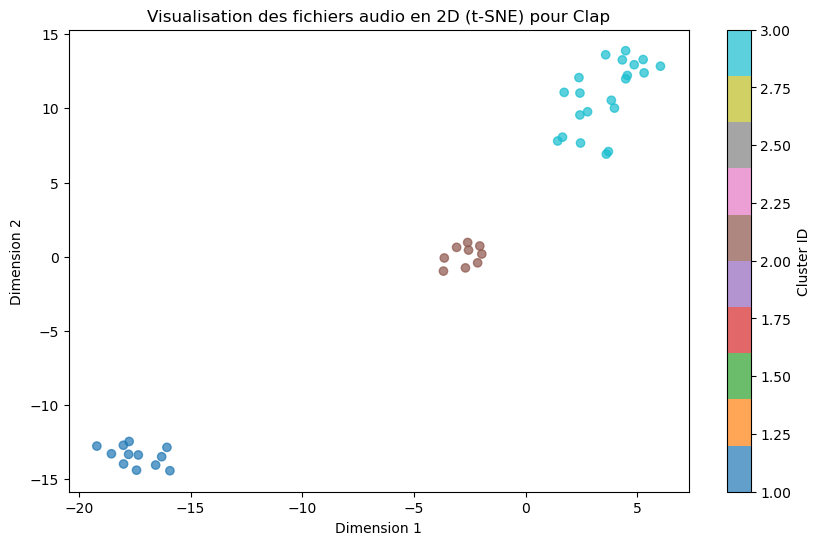

In [ ]:
# Réduction de dimension avec t-sne
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embeddings_2d = tsne.fit_transform(cosine_sim_matrixc)

# Définir un seuil pour regrouper les clusters
threshold = 5
clusters = fcluster(linkedc, threshold, criterion='distance')

# Affichage des points en 2d avec matplotlib
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster ID")
plt.title("Visualisation des fichiers audio en 2D (t-SNE) pour Clap")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Afficher les noms des fichiers
# For i, txt in enumerate(file_names):
# Plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.show()


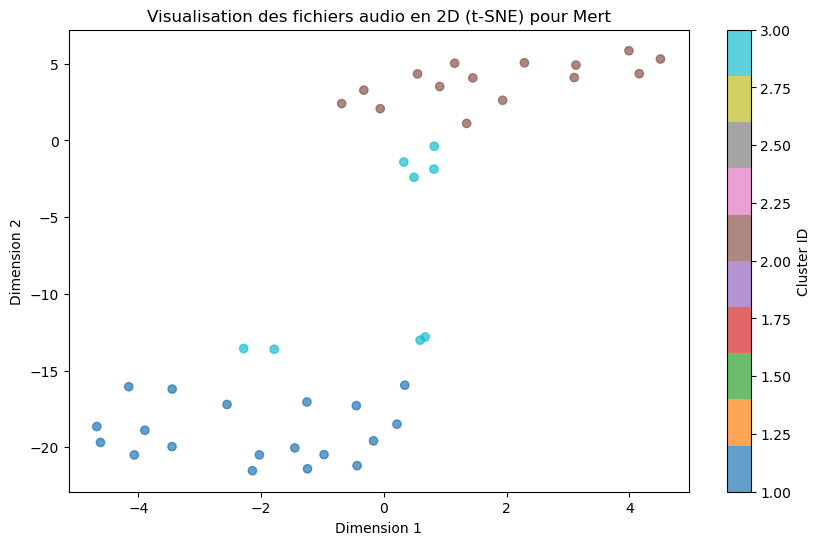

In [ ]:
# Réduction de dimension avec t-sne
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embeddings_2d = tsne.fit_transform(cosine_sim_matrixm)

# Définir un seuil pour regrouper les clusters
threshold = 10
clusters = fcluster(linkedm, threshold, criterion='distance')

# Affichage des points en 2d avec matplotlib
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster ID")
plt.title("Visualisation des fichiers audio en 2D (t-SNE) pour Mert")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Afficher les noms des fichiers
# For i, txt in enumerate(file_names):
# Plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.show()

In [ ]:
# Extraction des labels pour clap
file_to_cluster_clap = {file: cluster_id for cluster_id, files in cluster_dictc.items() for file in files}

# Extraction des labels pour mert
file_to_cluster_mert = {file: cluster_id for cluster_id, files in cluster_dictm.items() for file in files}

# Liste unique des fichiers présents dans les deux clusterings
file_names = list(file_to_cluster_clap.keys())  # Supposons que les fichiers sont les mêmes dans les deux clusterings

# Création des listes de labels alignées
labels_clap = [file_to_cluster_clap[file] for file in file_names]
labels_mert = [file_to_cluster_mert[file] for file in file_names]

# Affichage pour vérification
print("Fichiers :", file_names)
print("Labels CLAP :", labels_clap)
print("Labels MERT :", labels_mert)


Fichiers : ['Bam Bam - Hi-Q_vocals', 'Bessie Smith - My Sweetie Went Away_vocals', 'deef - Ein sonniger Tag mit dir_vocals', 'Dragon Or Emperor - Part of Me Says_vocals', 'Los Steaks - Sunday Girls_vocals', 'Mia Doi Todd - I gave you my home_vocals', 'Poland - Lying Machine_vocals', 'The Cute Lepers - Young Hearts_vocals', 'The Embarrassment - Patio Set_vocals', 'The J Arthur Keenes Band - The Boring World of Niels Bohr_vocals', 'The Oranges Band - Ride the Nuclear Wave_vocals', 'Wann - Happy Birthday_vocals', 'Bam Bam - Hi-Q_instrumental', 'Benji Cossa - New Flowers (Fast 4-track Version)_instrumental', 'Bessie Smith - My Sweetie Went Away_instrumental', 'David Rovics - We Just Want The World_instrumental', 'deef - Ein sonniger Tag mit dir_instrumental', 'Dragon Or Emperor - Part of Me Says_instrumental', 'Grand Mal - Children of Light_instrumental', 'Home Blitz - Secret Wave_instrumental', 'Josh Woodward - Cien Volando_instrumental', 'Los Steaks - Sunday Girls_instrumental', 'Mia Doi

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import entropy

# 1. adjusted rand index (ari)
ari = adjusted_rand_score(labels_clap, labels_mert)
print(f"Adjusted Rand Index (ARI) : {ari:.4f}")

# 2. normalized mutual information (nmi)
nmi = normalized_mutual_info_score(labels_clap, labels_mert)
print(f"Normalized Mutual Information (NMI) : {nmi:.4f}")

# 3. variation of information (vi)
def variation_of_information(labels1, labels2):
    contingency = np.histogram2d(labels1, labels2, bins=(max(labels1) + 1, max(labels2) + 1))[0]
    p_xy = contingency / contingency.sum()
    p_x = p_xy.sum(axis=1)
    p_y = p_xy.sum(axis=0)

    h_x = entropy(p_x)
    h_y = entropy(p_y)
    mi = np.nansum(p_xy * np.log(p_xy / (p_x[:, None] * p_y[None, :] + 1e-10) + 1e-10))

    return h_x + h_y - 2 * mi  # VI = H(X) + H(Y) - 2 I(X, Y)

vi = variation_of_information(labels_clap, labels_mert)
print(f"Variation of Information (VI) : {vi:.4f}")


Adjusted Rand Index (ARI) : -0.0274
Normalized Mutual Information (NMI) : 0.0521
Variation of Information (VI) : 2.0939
